In [ ]:
!pip install torch torchvision segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=9d1b5c7fd9e4990781d58cd859722048d719488f2585edf70b7a2c8f40be0227
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=a60dca15fd3a1f1a4356738b5bc0f061a5940a1cdb7942a6a8f462668c5d72e2
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
#import torchvision
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader, Dataset

In [1]:
!unzip "/content/drive/MyDrive/archive(1).zip" -d /content/data_forest/

Archive:  /content/drive/MyDrive/archive(1).zip
replace /content/data_forest/Forest Segmented/Forest Segmented/images/10452_sat_08.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import pandas as pd
meta_data_path = '/content/data_forest/Forest Segmented/Forest Segmented/meta_data.csv'
meta_data = pd.read_csv(meta_data_path)

meta_data.head()

,image,mask
0,10452_sat_08.jpg,10452_mask_08.jpg
1,10452_sat_18.jpg,10452_mask_18.jpg
2,111335_sat_00.jpg,111335_mask_00.jpg
3,111335_sat_01.jpg,111335_mask_01.jpg
4,111335_sat_02.jpg,111335_mask_02.jpg


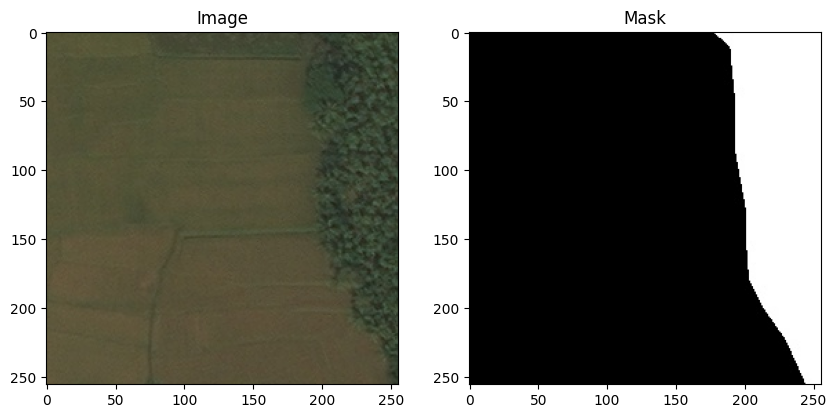

In [ ]:
import os
from PIL import Image
import numpy as np

segmented_path = "/content/data_forest/Forest Segmented/Forest Segmented"

image_path = os.path.join(segmented_path, 'images/10452_sat_08.jpg')
mask_path = os.path.join(segmented_path, 'masks/10452_mask_08.jpg')

image = Image.open(image_path)
mask = Image.open(mask_path)

image_np = np.array(image)
mask_np = np.array(mask)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image_np)
ax[0].set_title('Image')
ax[1].imshow(mask_np)
ax[1].set_title('Mask')
plt.show()

In [ ]:
images, masks = next(iter(train_loader))

TypeError: transpose() received an invalid combination of arguments - got (int, int, int), but expected one of:
 * (int dim0, int dim1)
 * (name dim0, name dim1)


In [ ]:
print(images.shape)
print(masks.shape)

(32, 256, 256, 3)
(32, 256, 256, 1)


In [4]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from albumentations import Compose, HorizontalFlip, RandomBrightnessContrast, RandomCrop
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
import albumentations as A

# Custom Dataset class for loading images and masks
class ForestDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, mask_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.images = sorted(os.listdir(images_dir))
        self.masks = sorted(os.listdir(masks_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])

        # Load image and mask
        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))  # Grayscale for binary segmentation

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        if self.mask_transform:
            mask_aug = self.mask_transform(image=mask)
            mask = mask_aug['image']

        return image, mask

# Directories for images and masks
images_dir = '/content/data_forest/Forest Segmented/Forest Segmented/images/'
masks_dir = '/content/data_forest/Forest Segmented/Forest Segmented/masks/'

# Create dataset without any transforms
full_dataset = ForestDataset(images_dir, masks_dir)

# Split into training (80%) and validation (20%)
train_size = int(0.8 * len(full_dataset))
valid_size = len(full_dataset) - train_size
train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])

# Define augmentations for training
train_image_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomCrop(height=256, width=256, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

train_mask_transform = A.Compose([
    A.RandomCrop(height=256, width=256, p=0.5),
    ToTensorV2()
])

# Transformation for validation (no augmentation, just normalization and to tensor)
valid_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Apply transformations to training and validation datasets
train_dataset.dataset.transform = train_image_transform
train_dataset.dataset.mask_transform = train_mask_transform
valid_dataset.dataset.transform = valid_transform
valid_dataset.dataset.mask_transform = valid_transform

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the DeepLabV3 model with a ResNet-50 backbone, pre-trained
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
num_classes = 1  # For binary segmentation
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))
model.to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Suitable for binary segmentation
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to calculate accuracy
def calculate_accuracy(outputs, masks):
    preds = torch.sigmoid(outputs) > 0.5  # Threshold for binary classification
    correct = (preds == masks).float()
    acc = correct.sum() / correct.numel()
    return acc.item()

# Training and validation functions
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0

    for images, masks in tqdm(train_loader, desc='Training'):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        train_accuracy += calculate_accuracy(outputs, masks) * images.size(0)

    epoch_loss = train_loss / len(train_loader.dataset)
    epoch_acc = train_accuracy / len(train_loader.dataset)

    return epoch_loss, epoch_acc

def validate_one_epoch(model, valid_loader, criterion, device):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0.0
    all_preds = []
    all_masks = []

    with torch.no_grad():
        for images, masks in tqdm(valid_loader, desc='Validating'):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']
            loss = criterion(outputs, masks)

            valid_loss += loss.item() * images.size(0)
            valid_accuracy += calculate_accuracy(outputs, masks) * images.size(0)

            # Store predictions and masks for mAP & PR calculation
            all_preds.extend(torch.sigmoid(outputs).cpu().numpy().flatten())
            all_masks.extend(masks.cpu().numpy().astype(int).flatten())

    # Calculate mean Average Precision (mAP)
    avg_precision = average_precision_score(all_masks, all_preds)

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(all_masks, all_preds)

    epoch_loss = valid_loss / len(valid_loader.dataset)
    epoch_acc = valid_accuracy / len(valid_loader.dataset)

    return epoch_loss, epoch_acc, avg_precision, (precision, recall)

# Training loop
num_epochs = 1
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
valid_mAPs = []
precision_recall_curves = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc, mAP, pr_curve = validate_one_epoch(model, valid_loader, criterion, device)

    # Logging the metrics
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)
    valid_mAPs.append(mAP)
    precision_recall_curves.append(pr_curve)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f}, Valid Acc: {valid_acc:.4f}, mAP: {mAP:.4f}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training:   1%|          | 1/128 [03:19<7:02:29, 199.60s/it]

ValueError: x and y must have same first dimension, but have shapes (2,) and (0,)

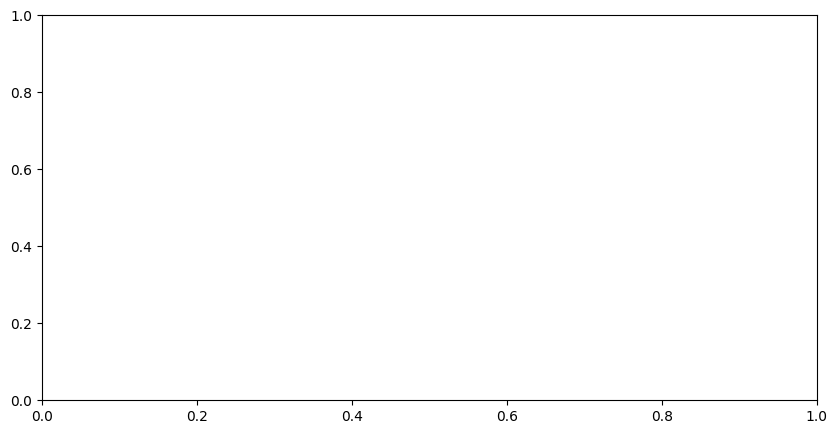

In [4]:
import matplotlib.pyplot as plt

# Plot Train and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

# Plot Train and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot Precision-Recall Curve for the last epoch
precision, recall = precision_recall_curves[-1]
plt.figure(figsize=(10, 5))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recal')